# Image Classification using Convolutional Neural Networks (CNN) on ASL Alphabet Dataset

## Objective


The goal is to implement a Convolutional Neural Network (CNN) for image classification on the American Sign Language (ASL) Alphabet dataset. The dataset consists of hand gesture images representing letters in the ASL alphabet. The provided code offers a starting point, and your tasks are detailed in the instructions below.

## Explanation

This project includes two parts, the first is building a CNN. The second deals with trying different hyperparameters etc, and discussing the outcomes.


### Part I





1. **Model Architecture**
  
  
  - Convolutional Layer 1:  a convolutional layer with 32 output channels, a 3x3 kernel size, a stride of 1, and a padding of 1.

  - ReLU Activation Function: a ReLU activation function after the first convolutional layer.

  -  MaxPooling Layer: a max-pooling layer with a 2x2 kernel size and a stride of 2.

  -  Convolutional Layer 2: a second convolutional layer with 64 output channels, a 3x3 kernel size, a stride of 1, and a padding of 1.

  - ReLU Activation Function.

  -  MaxPooling Layer: like above.

  - Flatten Layer: Reshapes the output of the second Pool layer into a one-dimensional tensor. The size is dynamically inferred based on the size of the feature maps.

  -  Fully Connected Layer 1 (Input Size: Dynamically Inferred Based on Previous Layer Output): Include a fully connected (linear) layer with an input size that is dynamically inferred based on the output size of the previous convolutional layer. Output size 128.

  - RelU Activation Function.

  -  Fully Connected Layer 2: a final fully connected (linear) layer with 29 output features, representing the 29 ASL labels (26 letters and 3 additional signs).

2. **Initalizing the Model and Model Training**
  
3. **Visualization**
  

4. **Model Evaluation**



### Part II

This part is about Trying different hyperparameters etc.



## Implementation

In [ ]:
# Cell 1: Import necessary libraries
# %pip install torch torchvision tqdm # uncomment in case you need to install packages

from PIL import Image
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for the progress bar
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, ConfusionMatrixDisplay
import seaborn as sns
import torch
import pandas as pd


In [ ]:
# !pip install opendatasets

In [ ]:
# import opendatasets as od
# od.download("https://www.kaggle.com/datasets/baoanhcr7/asl-alphabet")

In [ ]:
train_dir = "asl-alphabet/asl_alphabet_train/asl_alphabet_train" #'/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train'

## Exploring the dataset

By taking a look at the folders of the dataset, we can see we a have a balanced dataset with 3000 images per class.
We have a small test set of only 1 image per class.

label: 15
image shape: torch.Size([1, 3, 200, 200])


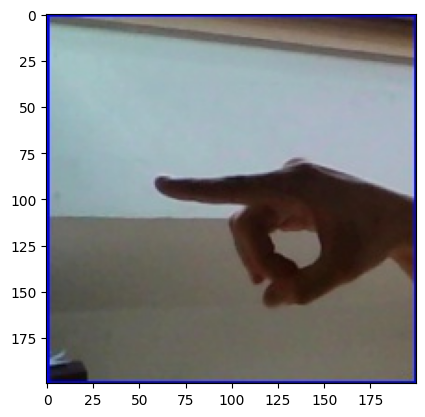

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor()
])
trainset = datasets.ImageFolder(root=train_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)
img, label = next(iter(trainloader))
print(f"label: {label.item()}")
print(f"image shape: {img.shape}")
plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

In [ ]:
def compute_mean_std(loader):
  mean = 0.
  std = 0.
  for images, _ in loader:
      images = images.view(images.size(0), images.size(1), -1) # flatten images
      mean += images.mean(2).sum(0) # calc mean of each channel
      std += images.std(2).sum(0)   # calc std of each channel
  return mean/len(loader.dataset), std/len(loader.dataset)

In [ ]:
#Compute mean and std of the images for normalizing

# transform = transforms.Compose([
#     transforms.ToTensor()
# ])
# trainset = datasets.ImageFolder(root=train_dir, transform=transform)
# trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
# ds_mean, ds_std = compute_mean_std(trainloader)

# calc once, we can skip calculations in the next runs
ds_mean, ds_std = torch.tensor([0.5189, 0.4990, 0.5145]), torch.tensor([0.2038, 0.2329, 0.2405])

In [ ]:
ds_mean, ds_std

(tensor([0.5189, 0.4990, 0.5145]), tensor([0.2038, 0.2329, 0.2405]))


- We will use a resize transormation - ensuring our input size is constant and can be relied upon in dimensions calculations after each of the layers, we also want to ensure our input is divisible by the reduced factor ( in our case 16)
We chose to downsample, not to overload with params.
- We will use ToTensor ensuring we are working with torch tensors.
- Finally, we will normalize our values, this is important because iamges can differ in thier distibution of pixelsvalues, we can have, for instance images with different lighting having higher/lower values than others, other then that it is important for a network to have constant and small range of numbers so it could converge easier.



In [ ]:
# Cell 2: Load ASL Alphabet dataset and apply transformations
input_size = 192
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(ds_mean, ds_std),
])

trainset = datasets.ImageFolder(root=train_dir, transform=transform)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)

In [ ]:
train_len = len(trainset)

In [ ]:
# Cell 3: Define the CNN architecture

class ASLNet(nn.Module):
  def __init__(self, input_size, num_channels):
    super(ASLNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(num_channels, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.flatten = nn.Flatten()
    # we use "same" convolutions - stride=padding=1
    # output dimentions = input dimentions
    # max pooling with kernel size = 2 and stride = 2
    # will reduce the spatial dimention by 2 - H/2, W/2 so overall n_pixels/4
    # We have 2 of those so we reduce by a factor of 16
    self.fc1 = nn.Linear((input_size*input_size*64)//16, 128)
    self.relu1 = nn.ReLU()
    self.fc2 = nn.Linear(128, 29)
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    return x


In [ ]:
# Cell 4: Initialize the CNN, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001
asl_net = ASLNet(input_size=input_size, num_channels=3).to(device)
loss_asl = nn.CrossEntropyLoss()
optimizer_asl = torch.optim.Adam(asl_net.parameters(), lr=learning_rate)

In [ ]:
# Cell 5: Training the CNN for ASL Alphabet classification
num_epochs = 5

if __name__ == '__main__':
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(tqdm(trainloader), 0):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = asl_net(inputs)

      loss = loss_asl(outputs, labels)
      optimizer_asl.zero_grad()

      loss.backward()
      optimizer_asl.step()

      running_loss += loss.item()

      if i % 1000 == 999:  # print every 1000 mini-batche
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0

    print('Finished Training')

  0%|          | 0/10875 [00:00<?, ?it/s]/home/afeldman/projects/.venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
  9%|▉         | 1012/10875 [00:17<02:27, 66.67it/s]

[1,  1000] loss: 22.780


 18%|█▊        | 2010/10875 [00:32<02:10, 68.08it/s]

[1,  2000] loss: 8.892


 28%|██▊       | 3012/10875 [00:47<01:56, 67.65it/s]

[1,  3000] loss: 5.734


 37%|███▋      | 4007/10875 [01:03<01:40, 68.63it/s]

[1,  4000] loss: 4.270


 46%|████▌     | 5010/10875 [01:18<01:30, 65.11it/s]

[1,  5000] loss: 3.618


 55%|█████▌    | 6012/10875 [01:33<01:17, 62.96it/s]

[1,  6000] loss: 2.859


 64%|██████▍   | 7011/10875 [01:49<00:57, 66.94it/s]

[1,  7000] loss: 2.598


 74%|███████▎  | 8009/10875 [02:04<00:45, 63.06it/s]

[1,  8000] loss: 2.270


 83%|████████▎ | 9013/10875 [02:19<00:26, 69.12it/s]

[1,  9000] loss: 2.157


 92%|█████████▏| 10010/10875 [02:34<00:13, 65.15it/s]

[1, 10000] loss: 1.687


100%|██████████| 10875/10875 [02:47<00:00, 64.99it/s]


Finished Training


  9%|▉         | 1006/10875 [00:15<02:32, 64.86it/s]

[2,  1000] loss: 1.107


 18%|█▊        | 2008/10875 [00:30<02:13, 66.42it/s]

[2,  2000] loss: 1.404


 28%|██▊       | 3008/10875 [00:45<01:53, 69.04it/s]

[2,  3000] loss: 1.201


 37%|███▋      | 4005/10875 [01:00<01:47, 64.11it/s]

[2,  4000] loss: 1.427


 46%|████▌     | 5007/10875 [01:15<01:31, 64.32it/s]

[2,  5000] loss: 1.204


 55%|█████▌    | 6009/10875 [01:31<01:14, 65.36it/s]

[2,  6000] loss: 1.011


 64%|██████▍   | 7010/10875 [01:46<00:55, 69.43it/s]

[2,  7000] loss: 1.138


 74%|███████▎  | 8007/10875 [02:01<00:43, 65.53it/s]

[2,  8000] loss: 1.030


 83%|████████▎ | 9007/10875 [02:17<00:29, 62.91it/s]

[2,  9000] loss: 0.932


 92%|█████████▏| 10007/10875 [02:32<00:12, 68.92it/s]

[2, 10000] loss: 1.165


100%|██████████| 10875/10875 [02:45<00:00, 65.68it/s]


Finished Training


  9%|▉         | 1006/10875 [00:16<02:31, 65.35it/s]

[3,  1000] loss: 0.634


 18%|█▊        | 2007/10875 [00:30<02:08, 69.23it/s]

[3,  2000] loss: 0.748


 28%|██▊       | 3011/10875 [00:45<01:55, 68.28it/s]

[3,  3000] loss: 0.864


 37%|███▋      | 4011/10875 [00:59<01:39, 69.30it/s]

[3,  4000] loss: 0.830


 46%|████▌     | 5010/10875 [01:14<01:23, 70.33it/s]

[3,  5000] loss: 0.664


 55%|█████▌    | 6010/10875 [01:28<01:07, 72.48it/s]

[3,  6000] loss: 0.917


 64%|██████▍   | 7006/10875 [01:44<00:56, 68.12it/s]

[3,  7000] loss: 0.660


 74%|███████▎  | 8009/10875 [01:59<00:40, 70.85it/s]

[3,  8000] loss: 0.614


 83%|████████▎ | 9007/10875 [02:12<00:21, 88.89it/s]

[3,  9000] loss: 0.640


 92%|█████████▏| 10008/10875 [02:25<00:12, 69.73it/s]

[3, 10000] loss: 0.633


100%|██████████| 10875/10875 [02:38<00:00, 68.80it/s]


Finished Training


  9%|▉         | 1010/10875 [00:14<02:26, 67.52it/s]

[4,  1000] loss: 0.468


 18%|█▊        | 2008/10875 [00:28<02:14, 66.01it/s]

[4,  2000] loss: 0.753


 28%|██▊       | 3014/10875 [00:43<01:48, 72.45it/s]

[4,  3000] loss: 0.672


 37%|███▋      | 4010/10875 [00:55<01:41, 67.76it/s]

[4,  4000] loss: 0.491


 46%|████▌     | 5011/10875 [01:10<01:28, 66.28it/s]

[4,  5000] loss: 0.602


 55%|█████▌    | 6015/10875 [01:24<01:05, 74.22it/s]

[4,  6000] loss: 0.629


 64%|██████▍   | 7010/10875 [01:39<00:53, 72.44it/s]

[4,  7000] loss: 0.583


 74%|███████▎  | 8010/10875 [01:54<00:41, 68.34it/s]

[4,  8000] loss: 0.558


 83%|████████▎ | 9012/10875 [02:09<00:23, 77.64it/s]

[4,  9000] loss: 0.410


 92%|█████████▏| 10009/10875 [02:22<00:10, 81.11it/s]

[4, 10000] loss: 0.598


100%|██████████| 10875/10875 [02:35<00:00, 70.11it/s]


Finished Training


  9%|▉         | 1009/10875 [00:15<02:29, 66.21it/s]

[5,  1000] loss: 0.500


 18%|█▊        | 2006/10875 [00:31<02:20, 63.01it/s]

[5,  2000] loss: 0.421


 28%|██▊       | 3008/10875 [00:46<01:58, 66.49it/s]

[5,  3000] loss: 0.531


 37%|███▋      | 4010/10875 [01:02<01:39, 68.82it/s]

[5,  4000] loss: 0.283


 46%|████▌     | 5011/10875 [01:17<01:26, 67.79it/s]

[5,  5000] loss: 0.623


 55%|█████▌    | 6013/10875 [01:33<01:12, 67.34it/s]

[5,  6000] loss: 0.467


 64%|██████▍   | 7012/10875 [01:48<00:59, 65.30it/s]

[5,  7000] loss: 0.616


 74%|███████▎  | 8013/10875 [02:01<00:36, 77.60it/s]

[5,  8000] loss: 0.482


 83%|████████▎ | 9007/10875 [02:14<00:28, 65.68it/s]

[5,  9000] loss: 0.462


 92%|█████████▏| 10010/10875 [02:29<00:13, 62.62it/s]

[5, 10000] loss: 0.365


100%|██████████| 10875/10875 [02:41<00:00, 67.21it/s]

Finished Training


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


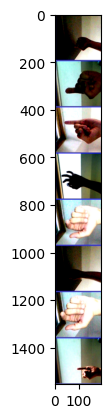

GroundTruth:     X     X     I     F     T     I     T     I
Predicted:     X     X     I     F     T     I     T     I


In [ ]:
# Cell 6: Visualize some predictions

dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  plt.imshow(torch.transpose(img, 0, 2).numpy())
  plt.show()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s' % chr(ord('A') + labels[j]) for j in range(len(labels))))

outputs = asl_net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted:', ' '.join('%5s' % chr(ord('A') + predicted[j]) for j in range(len(predicted))))


Predicted:  ['F', 'A', 'Y', 'L', 'N', 'Z', 'W', 'V']
Ground truth:  ['F', 'A', 'Y', 'L', 'N', 'Z', 'W', 'V']
Predicted:  ['X', '[', 'I', 'D', 'J', 'T', 'G', 'H']
Ground truth:  ['X', '[', 'I', 'D', 'J', 'T', 'G', 'H']
Predicted:  ['E', 'Q', 'M', 'O', 'P', 'C', '\\', 'R']
Ground truth:  ['E', 'Q', 'M', 'O', 'P', 'C', '\\', 'R']
Predicted:  ['U', 'B', 'S', ']', 'K']
Ground truth:  ['U', 'B', 'S', ']', 'K']
Test Accuracy: 100.00%


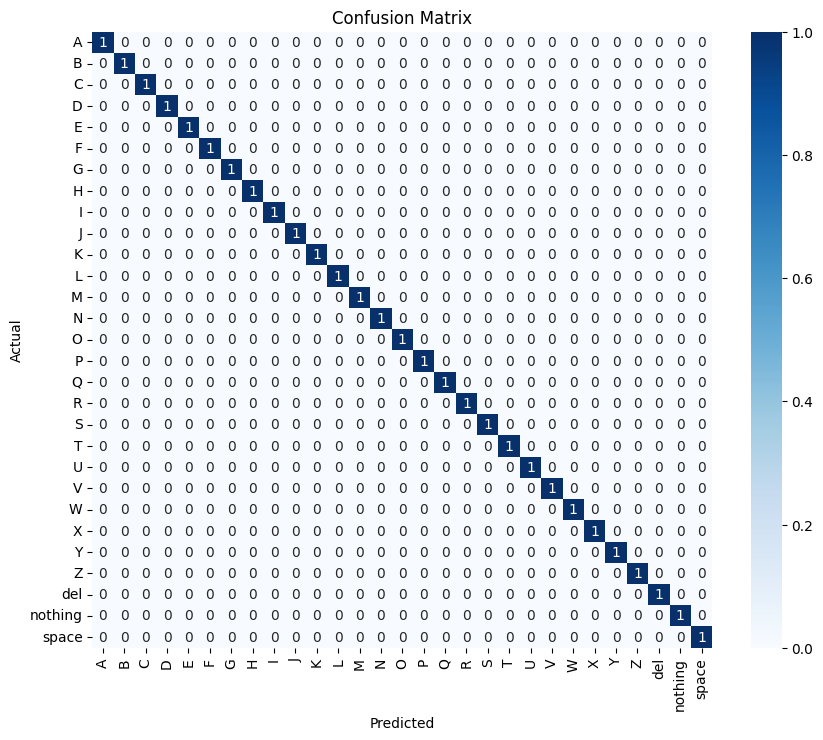

In [ ]:
# Cell 7 Evaluation on test

testset_path = "asl-alphabet/asl_alphabet_test/asl_alphabet_test" #'/content/asl-alphabet/asl_alphabet_train/asl_alphabet_test'

# for test_img in os.listdir(testset_path): #create a dir for each class to match training set format.
#   c = test_img.split('_')[0]
#   os.makedirs(os.path.join(testset_path, c), exist_ok=True)
#   shutil.move(os.path.join(testset_path, test_img), os.path.join(testset_path, c))


# Provide the path to your test set
# testset = SingleImageDataset(root=testset_path, transform=transform)
testset = datasets.ImageFolder(root=testset_path, transform=transform)

# Use the DataLoader to create batches
testloader = DataLoader(testset, batch_size=8, shuffle=True)
test_len = len(testset)

asl_net.eval()  # Set the model to evaluation mode

# Define the criterion for the test
criterion = nn.CrossEntropyLoss()

# Test the model on the test set
total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
  for inputs, labels in testloader:
    true_labels.extend(labels.numpy())
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = asl_net(inputs)

    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())
    print("Predicted: ", [chr(ord('A') + pred) for pred in predicted])
    print("Ground truth: ", [chr(ord('A') + label) for label in labels])

    total_samples += labels.size(0)
    total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples

print(f'Test Accuracy: {accuracy * 100:.2f}%')

confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
test_len / (train_len + test_len)

0.0003332222592469177

We are getting perfect results, it seems that the model generalizes well, but it is only on a small dataset.
We should validate/test the results on a larger set.

### Ways to improve and ideas:
- Hold a validation set and experiment with hyper parameters
- Plot train loss vs validation loss - if we suspect there is overfitting for instance (for now, on our test set it seems we generalize well but it is too small)
- Experiment with other losses - change loss to focal loss or NNL
- Deepen the net - add layers
- Train longer - more epochs combined with Early stopping - stop training according to performence on the validation set
- random tranformations and augmentations can make the model more robust, if we think we can get inference on images with different angles we can experiment with random rotation
- Check precision recall and f1
- add adaptive LR  - steps or reduce on plateu

## Part 2

In this part, we are comparing and tuninig different hyperparameters we will:
- hold a validation set for the comparison so so we will keep the test set "clean". Fuethermore, because the test set is small it seems like a good idea to explore on a larger set
- Compare the results with classification metrics which are usually more relible like recall, precision and F1.
In our case, we have a balanced dataset, so accuracy can be good as well, it is especially missleading when we have a minority class. We don't have a specific priority for FP or FN, there are no specific letters that swiching between them is more important. For those reasons we will use F1 score which has this balance between FP and FN, together with the accuracy, altough we can say they are equivalent in our case.

In [ ]:
# for reproducability let's set the seed manualy
gen = torch.Generator()
gen.manual_seed(0)
trainset_p2, valset_p2 = torch.utils.data.random_split(trainset, [0.8, 0.2], generator=gen)
input_size = 192
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(ds_mean, ds_std),
])

trainloader = DataLoader(trainset_p2, batch_size=8, shuffle=True, num_workers=2)
valloader = DataLoader(valset_p2, batch_size=8, shuffle=True, num_workers=2)
scores = pd.DataFrame()

1. Try three different activation functions in the ASLNet, discuss and compare the results of the changes.

In [ ]:
class ASLNet(nn.Module):
  def __init__(self, input_size, num_channels, activation='relu'):
    super(ASLNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(num_channels, 32, kernel_size=3, stride=1, padding=1),
        self.get_activation(activation),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        self.get_activation(activation),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear((input_size*input_size*64)//16, 128)
    self.act1 = self.get_activation(activation)
    self.fc2 = nn.Linear(128, 29)
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    return x

  def get_activation(self, activation):
        if activation == 'relu':
            return nn.ReLU()
        elif activation == 'sigmoid':
            return nn.Sigmoid()
        elif activation == 'tanh':
            return nn.Tanh()
        elif activation == 'leaky_relu':
            return nn.LeakyReLU()
        else:
            raise ValueError("Invalid activation. Supported activations:  'sigmoid', 'tanh', 'leaky_relu'")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learning_rate = 0.001
loss_asl = nn.CrossEntropyLoss()

### Leaky Relu

In [ ]:
asl_net = ASLNet(input_size=input_size, num_channels=3, activation="leaky_relu").to(device)
optimizer_asl = torch.optim.Adam(asl_net.parameters(), lr=learning_rate)

 12%|█▏        | 1013/8700 [00:15<01:50, 69.37it/s]

[1,  1000] loss: 2.078


 23%|██▎       | 2013/8700 [00:28<01:14, 89.66it/s]

[1,  2000] loss: 0.840


 35%|███▍      | 3009/8700 [00:39<01:04, 88.11it/s] 

[1,  3000] loss: 0.549


 46%|████▌     | 4010/8700 [00:53<01:12, 64.78it/s]

[1,  4000] loss: 0.400


 58%|█████▊    | 5010/8700 [01:08<00:52, 70.53it/s]

[1,  5000] loss: 0.301


 69%|██████▉   | 6008/8700 [01:23<00:42, 62.61it/s]

[1,  6000] loss: 0.279


 81%|████████  | 7010/8700 [01:38<00:25, 65.69it/s]

[1,  7000] loss: 0.239


 92%|█████████▏| 8007/8700 [01:53<00:10, 64.86it/s]

[1,  8000] loss: 0.205


100%|██████████| 8700/8700 [02:04<00:00, 70.14it/s]


Finished Training


 12%|█▏        | 1006/8700 [00:15<01:56, 66.30it/s]

[2,  1000] loss: 0.130


 23%|██▎       | 2009/8700 [00:30<01:32, 72.54it/s]

[2,  2000] loss: 0.191


 35%|███▍      | 3012/8700 [00:45<01:24, 67.16it/s]

[2,  3000] loss: 0.151


 46%|████▌     | 4011/8700 [01:00<01:10, 66.19it/s]

[2,  4000] loss: 0.159


 58%|█████▊    | 5008/8700 [01:14<00:44, 83.49it/s]

[2,  5000] loss: 0.153


 69%|██████▉   | 6016/8700 [01:26<00:31, 84.17it/s]

[2,  6000] loss: 0.141


 81%|████████  | 7014/8700 [01:38<00:19, 85.27it/s]

[2,  7000] loss: 0.140


 92%|█████████▏| 8006/8700 [01:52<00:11, 61.44it/s] 

[2,  8000] loss: 0.143


100%|██████████| 8700/8700 [02:03<00:00, 70.37it/s]


Finished Training


 12%|█▏        | 1009/8700 [00:14<01:54, 66.98it/s]

[3,  1000] loss: 0.115


 23%|██▎       | 2013/8700 [00:28<01:35, 70.11it/s]

[3,  2000] loss: 0.100


 35%|███▍      | 3017/8700 [00:40<00:55, 103.15it/s]

[3,  3000] loss: 0.088


 46%|████▌     | 4009/8700 [00:54<01:06, 70.59it/s] 

[3,  4000] loss: 0.154


 58%|█████▊    | 5007/8700 [01:10<00:57, 64.71it/s]

[3,  5000] loss: 0.354


 69%|██████▉   | 6010/8700 [01:25<00:43, 62.23it/s]

[3,  6000] loss: 0.114


 81%|████████  | 7008/8700 [01:40<00:24, 69.63it/s]

[3,  7000] loss: 0.128


 92%|█████████▏| 8013/8700 [01:56<00:09, 70.07it/s]

[3,  8000] loss: 0.149


100%|██████████| 8700/8700 [02:06<00:00, 68.74it/s]


Finished Training


 12%|█▏        | 1006/8700 [00:15<01:55, 66.89it/s]

[4,  1000] loss: 0.063


 23%|██▎       | 2008/8700 [00:29<01:42, 65.58it/s]

[4,  2000] loss: 0.399


 35%|███▍      | 3007/8700 [00:45<01:22, 68.74it/s]

[4,  3000] loss: 0.148


 46%|████▌     | 4007/8700 [01:00<01:08, 68.47it/s]

[4,  4000] loss: 0.176


 58%|█████▊    | 5008/8700 [01:15<00:52, 70.52it/s]

[4,  5000] loss: 0.086


 69%|██████▉   | 6011/8700 [01:29<00:34, 77.25it/s]

[4,  6000] loss: 0.186


 81%|████████  | 7007/8700 [01:44<00:26, 63.72it/s]

[4,  7000] loss: 0.122


 92%|█████████▏| 8012/8700 [01:59<00:09, 72.47it/s]

[4,  8000] loss: 0.109


100%|██████████| 8700/8700 [02:09<00:00, 67.18it/s]


Finished Training


 12%|█▏        | 1006/8700 [00:15<01:57, 65.66it/s]

[5,  1000] loss: 0.192


 23%|██▎       | 2008/8700 [00:30<01:38, 67.65it/s]

[5,  2000] loss: 0.117


 35%|███▍      | 3009/8700 [00:45<01:25, 66.90it/s]

[5,  3000] loss: 0.415


 46%|████▌     | 4007/8700 [01:01<01:08, 68.85it/s]

[5,  4000] loss: 0.084


 58%|█████▊    | 5012/8700 [01:16<00:59, 62.23it/s]

[5,  5000] loss: 0.122


 69%|██████▉   | 6008/8700 [01:31<00:39, 68.16it/s]

[5,  6000] loss: 0.197


 81%|████████  | 7010/8700 [01:47<00:26, 62.78it/s]

[5,  7000] loss: 0.159


 92%|█████████▏| 8011/8700 [02:02<00:10, 65.17it/s]

[5,  8000] loss: 0.151


100%|██████████| 8700/8700 [02:13<00:00, 65.32it/s]


Finished Training


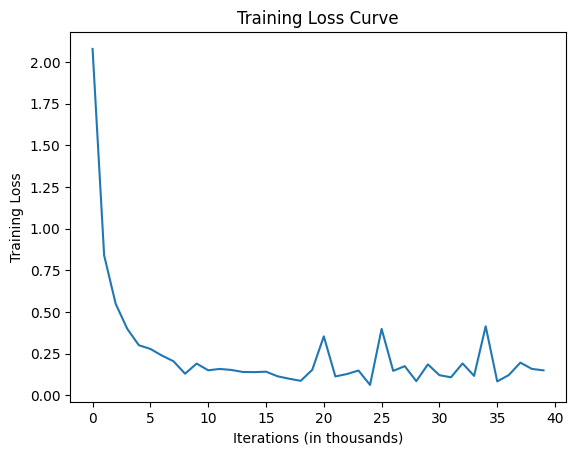

In [ ]:
num_epochs = 5
train_losses = []
if __name__ == '__main__':
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(tqdm(trainloader), 0):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = asl_net(inputs)

      loss = loss_asl(outputs, labels)
      optimizer_asl.zero_grad()

      loss.backward()
      optimizer_asl.step()

      running_loss += loss.item()

      if i % 1000 == 999:  # print every 1000 mini-batche
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
        train_losses.append(running_loss / 1000)
        running_loss = 0.0


    print('Finished Training')

# Plot the training loss curve
plt.plot(train_losses)
plt.xlabel('Iterations (in thousands)')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

/tmp/ipykernel_70718/472741385.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'leaky_relu' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  scores.loc[len(scores.index), ["activation", "accuracy", "recall", "precision", "f1"]] = "leaky_relu", accuracy, recall, precision, f1


Test Accuracy: 95.76%
Test recall: 95.76%
Test precision: 95.76%
Test F1 Score: 95.76%


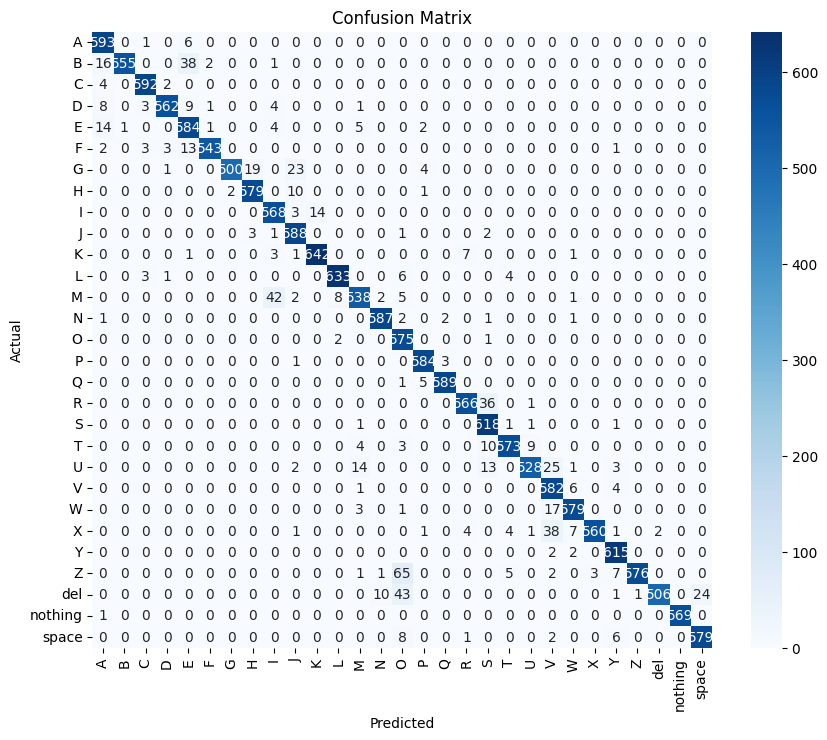

Test Accuracy: 95.76%


In [ ]:

asl_net.eval()  # Set the model to evaluation mode

# Define the criterion for the test
criterion = nn.CrossEntropyLoss()

# Test the model on the test set
total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    true_labels.extend(labels.numpy())
    labels = labels.to(device)
    outputs = asl_net(inputs)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())



    total_samples += labels.size(0)
    total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
recall = recall_score(true_labels, predicted_labels, average="micro")
precision = precision_score(true_labels, predicted_labels, average="micro")
f1 = f1_score(true_labels, predicted_labels, average="micro")
scores.loc[len(scores.index), ["activation", "accuracy", "recall", "precision", "f1"]] = "leaky_relu", accuracy, recall, precision, f1
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test recall: {recall * 100:.2f}%')
print(f'Test precision: {precision * 100:.2f}%')
print(f'Test F1 Score: {f1 * 100:.2f}%')

confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f'Test Accuracy: {accuracy * 100:.2f}%')

### Relu

In [ ]:
asl_net = ASLNet(input_size=input_size, num_channels=3, activation="relu").to(device)
optimizer_asl = torch.optim.Adam(asl_net.parameters(), lr=learning_rate)

 12%|█▏        | 1008/8700 [00:16<01:54, 67.16it/s]

[1,  1000] loss: 2.161


 23%|██▎       | 2009/8700 [00:31<01:47, 62.45it/s]

[1,  2000] loss: 0.735


 35%|███▍      | 3006/8700 [00:46<01:31, 62.10it/s]

[1,  3000] loss: 0.438


 46%|████▌     | 4007/8700 [01:01<01:13, 63.72it/s]

[1,  4000] loss: 0.321


 58%|█████▊    | 5009/8700 [01:16<00:52, 70.54it/s]

[1,  5000] loss: 0.245


 69%|██████▉   | 6013/8700 [01:31<00:39, 67.66it/s]

[1,  6000] loss: 0.212


 81%|████████  | 7009/8700 [01:46<00:24, 69.06it/s]

[1,  7000] loss: 0.198


 92%|█████████▏| 8011/8700 [02:01<00:10, 64.23it/s]

[1,  8000] loss: 0.176


100%|██████████| 8700/8700 [02:11<00:00, 65.97it/s]


Finished Training


 12%|█▏        | 1009/8700 [00:15<01:49, 70.50it/s]

[2,  1000] loss: 0.104


 23%|██▎       | 2013/8700 [00:31<01:39, 67.53it/s]

[2,  2000] loss: 0.109


 35%|███▍      | 3014/8700 [00:45<01:16, 74.58it/s]

[2,  3000] loss: 0.103


 46%|████▌     | 4011/8700 [00:59<01:04, 72.21it/s]

[2,  4000] loss: 0.096


 58%|█████▊    | 5011/8700 [01:14<00:55, 66.93it/s]

[2,  5000] loss: 0.103


 69%|██████▉   | 6008/8700 [01:29<00:38, 69.14it/s]

[2,  6000] loss: 0.104


 81%|████████  | 7011/8700 [01:44<00:25, 67.16it/s]

[2,  7000] loss: 0.092


 92%|█████████▏| 8007/8700 [02:00<00:11, 60.75it/s]

[2,  8000] loss: 0.079


100%|██████████| 8700/8700 [02:10<00:00, 66.49it/s]


Finished Training


 12%|█▏        | 1010/8700 [00:15<01:59, 64.47it/s]

[3,  1000] loss: 0.053


 23%|██▎       | 2012/8700 [00:30<01:21, 82.17it/s]

[3,  2000] loss: 0.067


 35%|███▍      | 3012/8700 [00:44<01:22, 69.30it/s]

[3,  3000] loss: 0.073


 46%|████▌     | 4007/8700 [00:59<01:11, 65.45it/s]

[3,  4000] loss: 0.057


 58%|█████▊    | 5007/8700 [01:15<01:04, 57.25it/s]

[3,  5000] loss: 0.049


 69%|██████▉   | 6009/8700 [01:30<00:39, 67.59it/s]

[3,  6000] loss: 0.071


 81%|████████  | 7010/8700 [01:46<00:27, 61.60it/s]

[3,  7000] loss: 0.068


 92%|█████████▏| 8010/8700 [02:01<00:10, 65.93it/s]

[3,  8000] loss: 0.059


100%|██████████| 8700/8700 [02:12<00:00, 65.79it/s]


Finished Training


 12%|█▏        | 1010/8700 [00:15<01:59, 64.52it/s]

[4,  1000] loss: 0.047


 23%|██▎       | 2012/8700 [00:31<01:38, 67.94it/s]

[4,  2000] loss: 0.044


 35%|███▍      | 3006/8700 [00:45<01:23, 67.90it/s]

[4,  3000] loss: 0.066


 46%|████▌     | 4013/8700 [01:00<01:09, 67.09it/s]

[4,  4000] loss: 0.050


 58%|█████▊    | 5007/8700 [01:15<00:54, 67.98it/s]

[4,  5000] loss: 0.047


 69%|██████▉   | 6007/8700 [01:31<00:40, 66.34it/s]

[4,  6000] loss: 0.054


 81%|████████  | 7009/8700 [01:46<00:24, 69.80it/s]

[4,  7000] loss: 0.063


 92%|█████████▏| 8013/8700 [02:01<00:10, 63.65it/s]

[4,  8000] loss: 0.049


100%|██████████| 8700/8700 [02:12<00:00, 65.77it/s]


Finished Training


 12%|█▏        | 1007/8700 [00:15<02:12, 57.88it/s]

[5,  1000] loss: 0.044


 23%|██▎       | 2009/8700 [00:30<01:52, 59.46it/s]

[5,  2000] loss: 0.056


 35%|███▍      | 3006/8700 [00:45<01:19, 71.66it/s]

[5,  3000] loss: 0.030


 46%|████▌     | 4009/8700 [01:00<01:07, 69.49it/s]

[5,  4000] loss: 0.018


 58%|█████▊    | 5013/8700 [01:15<00:51, 71.83it/s]

[5,  5000] loss: 0.052


 69%|██████▉   | 6011/8700 [01:29<00:41, 64.81it/s]

[5,  6000] loss: 0.058


 81%|████████  | 7009/8700 [01:44<00:25, 65.64it/s]

[5,  7000] loss: 0.030


 92%|█████████▏| 8009/8700 [01:59<00:09, 70.65it/s]

[5,  8000] loss: 0.035


100%|██████████| 8700/8700 [02:10<00:00, 66.79it/s]


Finished Training


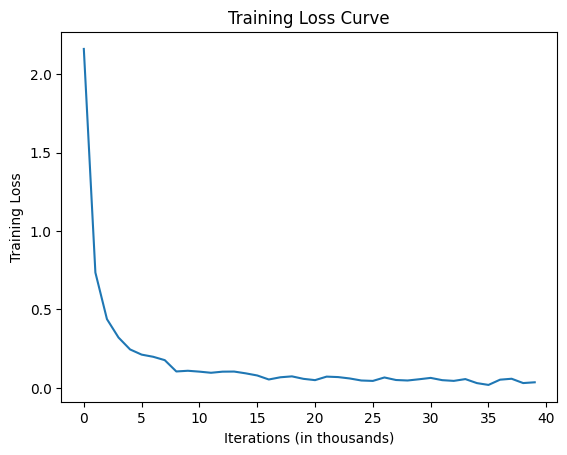

In [ ]:
num_epochs = 5
train_losses = []
if __name__ == '__main__':
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(tqdm(trainloader), 0):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = asl_net(inputs)

      loss = loss_asl(outputs, labels)
      optimizer_asl.zero_grad()

      loss.backward()
      optimizer_asl.step()

      running_loss += loss.item()

      if i % 1000 == 999:  # print every 1000 mini-batche
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
        train_losses.append(running_loss / 1000)
        running_loss = 0.0


    print('Finished Training')

# Plot the training loss curve
plt.plot(train_losses)
plt.xlabel('Iterations (in thousands)')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

Test Accuracy: 98.06%
Test recall: 98.06%
Test precision: 98.06%
Test F1 Score: 98.06%


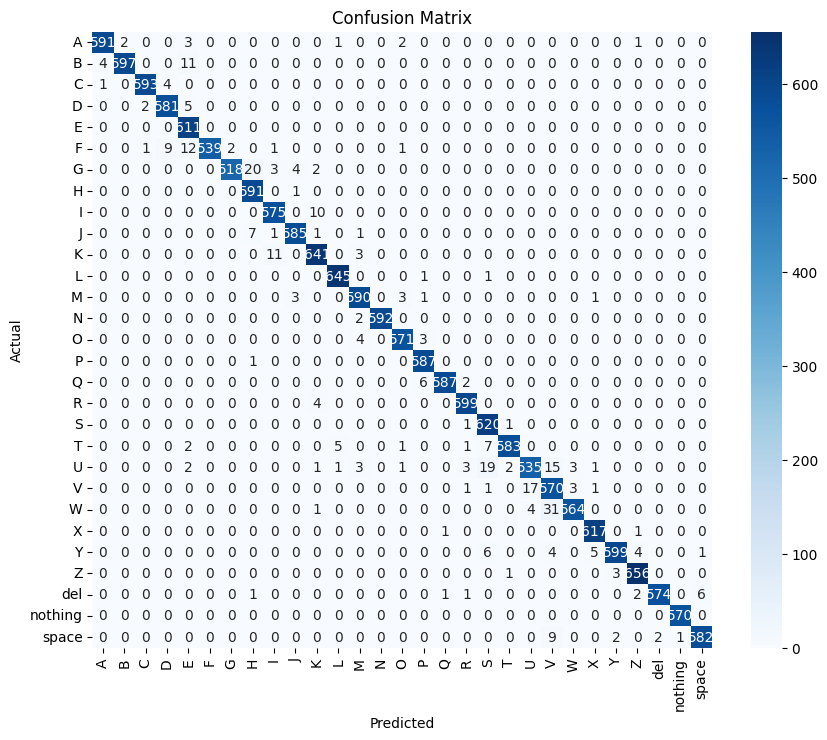

Test Accuracy: 98.06%


In [ ]:

asl_net.eval()  # Set the model to evaluation mode

# Define the criterion for the test
criterion = nn.CrossEntropyLoss()

# Test the model on the test set
total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    true_labels.extend(labels.numpy())
    labels = labels.to(device)
    outputs = asl_net(inputs)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())

    # print("Predicted: ", [chr(ord('A') + pred) for pred in predicted])
    # print("Ground truth: ", [chr(ord('A') + label) for label in labels])

    total_samples += labels.size(0)
    total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
recall = recall_score(true_labels, predicted_labels, average="micro")
precision = precision_score(true_labels, predicted_labels, average="micro")
f1 = f1_score(true_labels, predicted_labels, average="micro")
scores.loc[len(scores.index), ["activation", "accuracy", "recall", "precision", "f1"]] = "relu", accuracy, recall, precision, f1
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test recall: {recall * 100:.2f}%')
print(f'Test precision: {precision * 100:.2f}%')
print(f'Test F1 Score: {f1 * 100:.2f}%')

confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f'Test Accuracy: {accuracy * 100:.2f}%')

### Sigmoid

In [ ]:
asl_net = ASLNet(input_size=input_size, num_channels=3, activation="sigmoid").to(device)
optimizer_asl = torch.optim.Adam(asl_net.parameters(), lr=learning_rate)

 12%|█▏        | 1013/8700 [00:15<01:49, 70.21it/s]

[1,  1000] loss: 3.395


 23%|██▎       | 2010/8700 [00:30<01:40, 66.54it/s]

[1,  2000] loss: 3.391


 35%|███▍      | 3007/8700 [00:46<01:37, 58.48it/s]

[1,  3000] loss: 3.390


 46%|████▌     | 4007/8700 [01:01<01:12, 65.16it/s]

[1,  4000] loss: 3.390


 58%|█████▊    | 5011/8700 [01:17<00:51, 71.60it/s]

[1,  5000] loss: 3.391


 69%|██████▉   | 6008/8700 [01:31<00:39, 67.89it/s]

[1,  6000] loss: 3.391


 81%|████████  | 7011/8700 [01:46<00:24, 68.86it/s]

[1,  7000] loss: 3.388


 92%|█████████▏| 8014/8700 [02:00<00:07, 88.32it/s]

[1,  8000] loss: 3.390


100%|██████████| 8700/8700 [02:10<00:00, 66.58it/s]


Finished Training


 12%|█▏        | 1009/8700 [00:15<01:51, 68.85it/s]

[2,  1000] loss: 3.390


 23%|██▎       | 2009/8700 [00:29<01:36, 69.67it/s]

[2,  2000] loss: 3.390


 35%|███▍      | 3013/8700 [00:44<01:22, 69.12it/s]

[2,  3000] loss: 3.390


 46%|████▌     | 4011/8700 [00:58<01:07, 69.08it/s]

[2,  4000] loss: 3.390


 58%|█████▊    | 5006/8700 [01:13<00:53, 68.45it/s]

[2,  5000] loss: 3.391


 69%|██████▉   | 6013/8700 [01:27<00:39, 68.62it/s]

[2,  6000] loss: 3.391


 81%|████████  | 7007/8700 [01:42<00:24, 67.77it/s]

[2,  7000] loss: 3.389


 92%|█████████▏| 8009/8700 [01:57<00:10, 65.03it/s]

[2,  8000] loss: 3.391


100%|██████████| 8700/8700 [02:07<00:00, 68.09it/s]


Finished Training


 12%|█▏        | 1006/8700 [00:15<01:52, 68.20it/s]

[3,  1000] loss: 3.390


 23%|██▎       | 2007/8700 [00:30<01:42, 65.42it/s]

[3,  2000] loss: 3.390


 35%|███▍      | 3007/8700 [00:46<01:36, 59.06it/s]

[3,  3000] loss: 3.389


 46%|████▌     | 4006/8700 [01:01<01:16, 61.25it/s]

[3,  4000] loss: 3.391


 58%|█████▊    | 5007/8700 [01:16<01:00, 60.95it/s]

[3,  5000] loss: 3.392


 69%|██████▉   | 6009/8700 [01:31<00:41, 65.47it/s]

[3,  6000] loss: 3.391


 81%|████████  | 7008/8700 [01:47<00:25, 65.09it/s]

[3,  7000] loss: 3.387


 92%|█████████▏| 8012/8700 [02:02<00:10, 64.54it/s]

[3,  8000] loss: 3.389


100%|██████████| 8700/8700 [02:13<00:00, 65.25it/s]


Finished Training


 12%|█▏        | 1008/8700 [00:15<01:55, 66.61it/s]

[4,  1000] loss: 3.389


 23%|██▎       | 2009/8700 [00:30<01:46, 62.74it/s]

[4,  2000] loss: 3.389


 35%|███▍      | 3010/8700 [00:45<01:28, 64.33it/s]

[4,  3000] loss: 3.390


 46%|████▌     | 4013/8700 [01:01<01:08, 68.50it/s]

[4,  4000] loss: 3.392


 58%|█████▊    | 5013/8700 [01:16<00:55, 66.32it/s]

[4,  5000] loss: 3.390


 69%|██████▉   | 6007/8700 [01:32<00:45, 59.25it/s]

[4,  6000] loss: 3.390


 81%|████████  | 7010/8700 [01:48<00:26, 62.66it/s]

[4,  7000] loss: 3.389


 92%|█████████▏| 8013/8700 [02:03<00:10, 68.46it/s]

[4,  8000] loss: 3.390


100%|██████████| 8700/8700 [02:13<00:00, 65.31it/s]


Finished Training


 12%|█▏        | 1006/8700 [00:14<01:53, 67.70it/s]

[5,  1000] loss: 3.389


 23%|██▎       | 2014/8700 [00:29<01:34, 70.54it/s]

[5,  2000] loss: 3.390


 35%|███▍      | 3012/8700 [00:44<01:22, 69.05it/s]

[5,  3000] loss: 3.390


 46%|████▌     | 4007/8700 [01:00<01:11, 65.60it/s]

[5,  4000] loss: 3.392


 58%|█████▊    | 5012/8700 [01:15<00:55, 66.01it/s]

[5,  5000] loss: 3.388


 69%|██████▉   | 6012/8700 [01:29<00:37, 71.90it/s]

[5,  6000] loss: 3.391


 81%|████████  | 7012/8700 [01:43<00:23, 71.52it/s]

[5,  7000] loss: 3.388


 92%|█████████▏| 8016/8700 [01:55<00:07, 91.98it/s]

[5,  8000] loss: 3.388


100%|██████████| 8700/8700 [02:05<00:00, 69.37it/s]


Finished Training


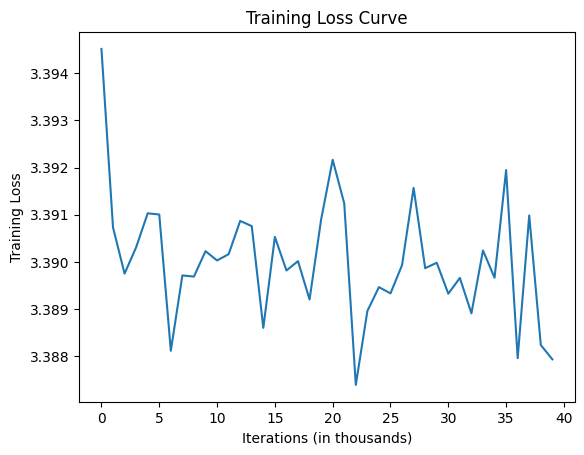

In [ ]:
num_epochs = 5
train_losses = []
if __name__ == '__main__':
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(tqdm(trainloader), 0):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = asl_net(inputs)

      loss = loss_asl(outputs, labels)
      optimizer_asl.zero_grad()

      loss.backward()
      optimizer_asl.step()

      running_loss += loss.item()

      if i % 1000 == 999:  # print every 1000 mini-batche
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
        train_losses.append(running_loss / 1000)
        running_loss = 0.0


    print('Finished Training')

# Plot the training loss curve
plt.plot(train_losses)
plt.xlabel('Iterations (in thousands)')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

Predicted:  ['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K']
Ground truth:  ['U', 'P', 'Z', 'J', 'O', 'P', 'F', 'M']
Predicted:  ['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K']
Ground truth:  ['R', 'Y', 'Y', 'D', 'I', 'V', 'A', 'A']
Predicted:  ['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K']
Ground truth:  ['F', 'V', 'U', 'J', 'T', 'J', 'E', 'C']
Predicted:  ['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K']
Ground truth:  ['R', 'O', 'E', 'O', 'D', '\\', 'K', 'Z']
Predicted:  ['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K']
Ground truth:  ['B', 'Y', 'P', 'L', 'Y', 'C', 'K', 'C']
Predicted:  ['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K']
Ground truth:  ['V', 'B', 'E', 'H', 'V', 'L', 'U', 'D']
Predicted:  ['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K']
Ground truth:  ['V', 'Z', 'T', 'S', 'P', 'R', 'K', 'D']
Predicted:  ['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K']
Ground truth:  ['K', 'U', 'I', 'J', 'P', 'O', 'R', 'U']
Predicted:  ['K', 'K', 'K', 'K', 'K', 'K', 'K', 'K']
Ground truth:  ['[', 'Z', 'F', 'I', 'G', 'B', ']', 'W']
Predicted:  ['K', 

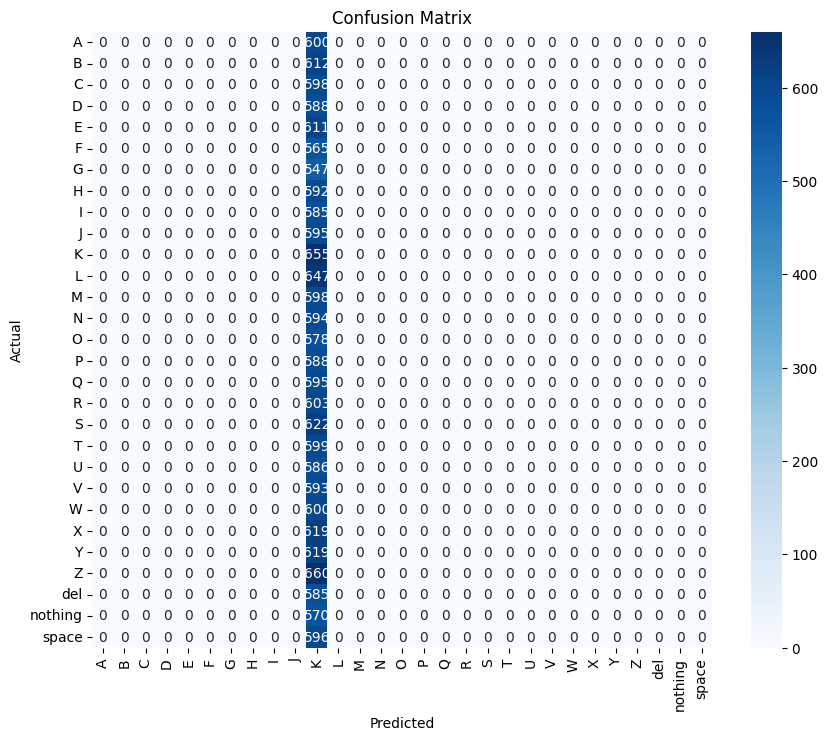

Test Accuracy: 3.76%


In [ ]:

asl_net.eval()  # Set the model to evaluation mode

# Define the criterion for the test
criterion = nn.CrossEntropyLoss()

# Test the model on the test set
total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    true_labels.extend(labels.numpy())
    labels = labels.to(device)
    outputs = asl_net(inputs)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())

    print("Predicted: ", [chr(ord('A') + pred) for pred in predicted])
    print("Ground truth: ", [chr(ord('A') + label) for label in labels])

    total_samples += labels.size(0)
    total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
recall = recall_score(true_labels, predicted_labels, average="micro")
precision = precision_score(true_labels, predicted_labels, average="micro")
f1 = f1_score(true_labels, predicted_labels, average="micro")
scores.loc[len(scores.index), ["activation", "accuracy", "recall", "precision", "f1"]] = "sigmoid", accuracy, recall, precision, f1
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test recall: {recall * 100:.2f}%')
print(f'Test precision: {precision * 100:.2f}%')
print(f'Test F1 Score: {f1 * 100:.2f}%')

confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f'Test Accuracy: {accuracy * 100:.2f}%')

We can see we are underfitting, because sigmoid limiting us to numbers between 0 and 1 putting it in the network doesn't make much sense, the network cant get the right predicitons and it is "stuck" on one class.

### Tanh

In [ ]:
asl_net = ASLNet(input_size=input_size, num_channels=3, activation="tanh").to(device)
optimizer_asl = torch.optim.Adam(asl_net.parameters(), lr=learning_rate)

 12%|█▏        | 1011/8700 [00:14<01:42, 75.03it/s]

[1,  1000] loss: 3.309


 23%|██▎       | 2013/8700 [00:29<01:40, 66.44it/s]

[1,  2000] loss: 3.098


 35%|███▍      | 3005/8700 [00:44<01:34, 60.41it/s]

[1,  3000] loss: 2.961


 46%|████▌     | 4008/8700 [00:59<01:17, 60.38it/s]

[1,  4000] loss: 2.908


 58%|█████▊    | 5011/8700 [01:14<00:52, 70.44it/s]

[1,  5000] loss: 2.841


 69%|██████▉   | 6007/8700 [01:29<00:41, 65.67it/s]

[1,  6000] loss: 2.791


 81%|████████  | 7007/8700 [01:45<00:24, 69.28it/s]

[1,  7000] loss: 2.709


 92%|█████████▏| 8015/8700 [01:59<00:08, 82.44it/s]

[1,  8000] loss: 2.699


100%|██████████| 8700/8700 [02:10<00:00, 66.89it/s]


Finished Training


 12%|█▏        | 1005/8700 [00:14<02:04, 61.98it/s]

[2,  1000] loss: 2.663


 23%|██▎       | 2009/8700 [00:29<01:36, 69.53it/s]

[2,  2000] loss: 2.698


 35%|███▍      | 3005/8700 [00:45<01:23, 68.17it/s]

[2,  3000] loss: 2.649


 46%|████▌     | 4012/8700 [01:00<01:12, 64.23it/s]

[2,  4000] loss: 2.742


 58%|█████▊    | 5008/8700 [01:15<00:59, 61.84it/s]

[2,  5000] loss: 2.633


 69%|██████▉   | 6012/8700 [01:30<00:39, 68.23it/s]

[2,  6000] loss: 2.622


 81%|████████  | 7006/8700 [01:45<00:25, 67.33it/s]

[2,  7000] loss: 2.635


 92%|█████████▏| 8007/8700 [02:00<00:10, 63.56it/s]

[2,  8000] loss: 2.592


100%|██████████| 8700/8700 [02:11<00:00, 66.39it/s]


Finished Training


 12%|█▏        | 1007/8700 [00:15<01:56, 66.24it/s]

[3,  1000] loss: 2.580


 23%|██▎       | 2010/8700 [00:30<01:40, 66.59it/s]

[3,  2000] loss: 3.016


 35%|███▍      | 3009/8700 [00:44<01:23, 68.41it/s]

[3,  3000] loss: 2.565


 46%|████▌     | 4012/8700 [00:59<01:05, 71.91it/s]

[3,  4000] loss: 2.561


 58%|█████▊    | 5011/8700 [01:14<00:52, 69.83it/s]

[3,  5000] loss: 2.511


 69%|██████▉   | 6010/8700 [01:29<00:39, 67.32it/s]

[3,  6000] loss: 2.531


 81%|████████  | 7010/8700 [01:44<00:24, 68.14it/s]

[3,  7000] loss: 2.520


 92%|█████████▏| 8007/8700 [01:59<00:09, 70.20it/s]

[3,  8000] loss: 2.546


100%|██████████| 8700/8700 [02:08<00:00, 67.76it/s]


Finished Training


 12%|█▏        | 1012/8700 [00:14<01:50, 69.47it/s]

[4,  1000] loss: 2.578


 23%|██▎       | 2014/8700 [00:29<01:28, 75.23it/s]

[4,  2000] loss: 2.542


 35%|███▍      | 3007/8700 [00:43<01:26, 66.05it/s]

[4,  3000] loss: 2.544


 46%|████▌     | 4009/8700 [00:58<01:16, 61.10it/s]

[4,  4000] loss: 2.534


 58%|█████▊    | 5008/8700 [01:13<00:52, 70.73it/s]

[4,  5000] loss: 2.497


 69%|██████▉   | 6008/8700 [01:27<00:41, 65.22it/s]

[4,  6000] loss: 2.483


 81%|████████  | 7012/8700 [01:42<00:24, 70.06it/s]

[4,  7000] loss: 2.479


 92%|█████████▏| 8013/8700 [01:56<00:09, 74.50it/s]

[4,  8000] loss: 2.453


100%|██████████| 8700/8700 [02:06<00:00, 68.59it/s]


Finished Training


 12%|█▏        | 1010/8700 [00:16<01:58, 64.69it/s]

[5,  1000] loss: 2.442


 23%|██▎       | 2010/8700 [00:31<01:43, 64.54it/s]

[5,  2000] loss: 2.487


 35%|███▍      | 3008/8700 [00:46<01:33, 60.95it/s]

[5,  3000] loss: 2.426


 46%|████▌     | 4009/8700 [01:02<01:11, 65.65it/s]

[5,  4000] loss: 2.447


 58%|█████▊    | 5009/8700 [01:18<00:58, 62.78it/s]

[5,  5000] loss: 2.453


 69%|██████▉   | 6013/8700 [01:33<00:40, 65.55it/s]

[5,  6000] loss: 2.407


 81%|████████  | 7012/8700 [01:49<00:25, 65.00it/s]

[5,  7000] loss: 2.401


 92%|█████████▏| 8007/8700 [02:05<00:10, 64.22it/s]

[5,  8000] loss: 2.377


100%|██████████| 8700/8700 [02:17<00:00, 63.42it/s]


Finished Training


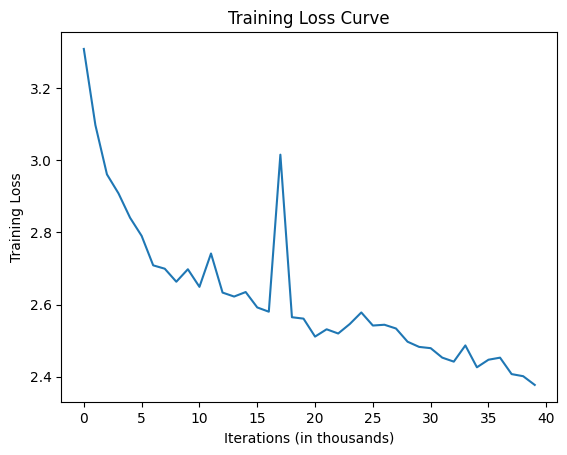

In [ ]:
num_epochs = 5
train_losses = []
if __name__ == '__main__':
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(tqdm(trainloader), 0):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = asl_net(inputs)

      loss = loss_asl(outputs, labels)
      optimizer_asl.zero_grad()

      loss.backward()
      optimizer_asl.step()

      running_loss += loss.item()

      if i % 1000 == 999:  # print every 1000 mini-batche
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
        train_losses.append(running_loss / 1000)
        running_loss = 0.0


    print('Finished Training')

# Plot the training loss curve
plt.plot(train_losses)
plt.xlabel('Iterations (in thousands)')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

Test Accuracy: 28.25%
Test recall: 28.25%
Test precision: 28.25%
Test F1 Score: 28.25%


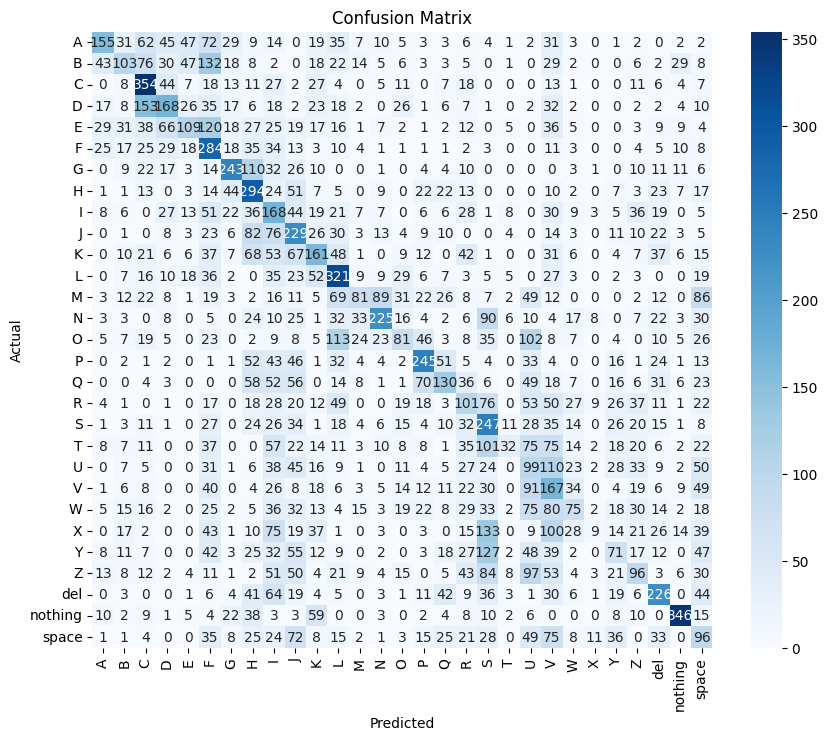

Test Accuracy: 28.25%


In [ ]:

asl_net.eval()  # Set the model to evaluation mode

# Define the criterion for the test
criterion = nn.CrossEntropyLoss()

# Test the model on the test set
total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    true_labels.extend(labels.numpy())
    labels = labels.to(device)
    outputs = asl_net(inputs)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())


    total_samples += labels.size(0)
    total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
recall = recall_score(true_labels, predicted_labels, average="micro")
precision = precision_score(true_labels, predicted_labels, average="micro")
f1 = f1_score(true_labels, predicted_labels, average="micro")
scores.loc[len(scores.index), ["activation", "accuracy", "recall", "precision", "f1"]] = "tanh", accuracy, recall, precision, f1
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test recall: {recall * 100:.2f}%')
print(f'Test precision: {precision * 100:.2f}%')
print(f'Test F1 Score: {f1 * 100:.2f}%')

confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f'Test Accuracy: {accuracy * 100:.2f}%')

### Activations comparison

In [ ]:
scores

,activation,accuracy,recall,precision,f1
0,leaky_relu,0.957644,0.957644,0.957644,0.957644
1,relu,0.980632,0.980632,0.980632,0.980632
2,sigmoid,0.037644,0.037644,0.037644,0.037644
3,tanh,0.282529,0.282529,0.282529,0.282529


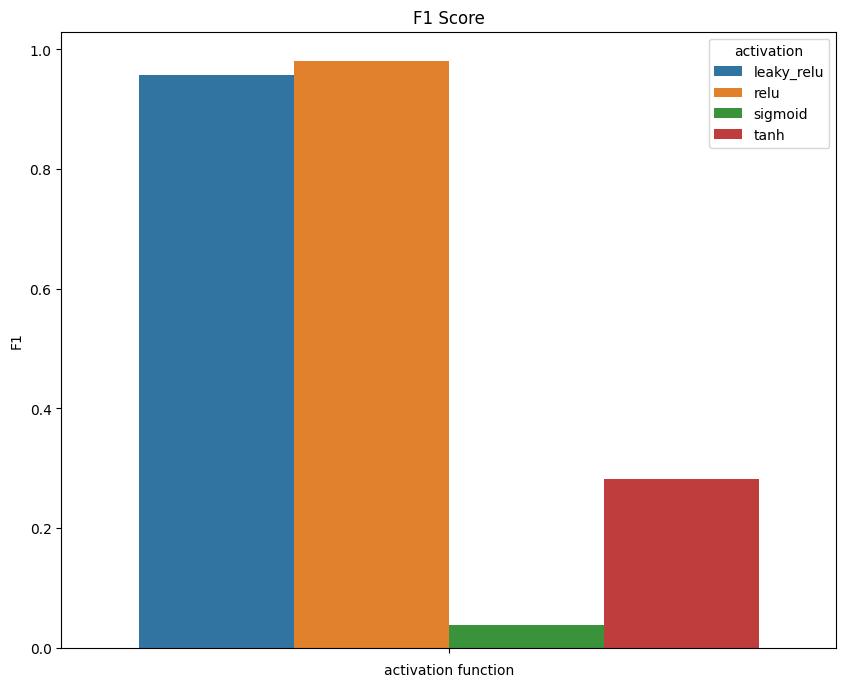

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(scores, y="accuracy", hue="activation")
plt.xlabel('activation function')
plt.ylabel('F1')
plt.title('F1 Score')
plt.show()

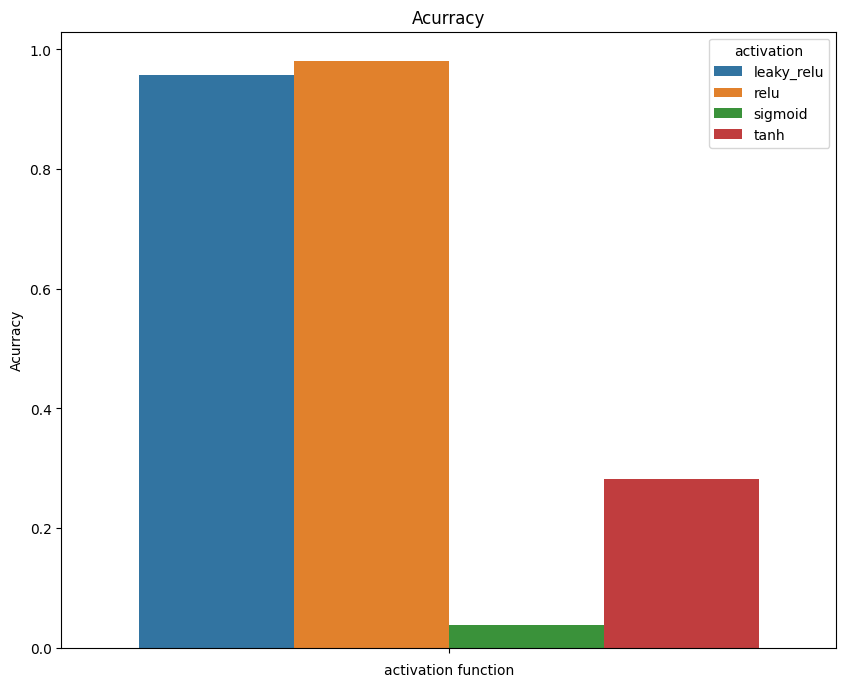

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(scores, y="accuracy", hue="activation")
plt.xlabel('activation function')
plt.ylabel('Acurracy')
plt.title('Acurracy')
plt.show()

We can see that relu performs better than all the othr activation functions we tried. WE can also see that the two functions that limit the upper values, sigmoid - between 0 and 1 and tanh between -1 and 1, perfermed significally worse, sigmoid which limits the most was the worse. We can conclude we need those larger numbers and larger range throughout the net to be able to classify correctly the different classes.

### SGD

2. Change the implemented optimizer to SGD with learning decay, discuss and compare the result of this change.

In [ ]:

learning_rate = 0.001
asl_net = ASLNet(input_size=input_size, num_channels=3).to(device)
loss_asl = nn.CrossEntropyLoss()
optimizer_asl = torch.optim.SGD(asl_net.parameters(), lr=learning_rate)
# Decays the learning rate of each parameter group by gamma every step_size epochs
# By looking at previus runs, after 1 epoch the loss curve starts to jitter up and down and generally less smooth, lets reduce the learning rate a bit at each epoch so we will make smaller steps
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_asl,  step_size=1, gamma=0.8)


 12%|█▏        | 1013/8700 [00:14<01:36, 79.42it/s]

[1,  1000] loss: 3.128


 23%|██▎       | 2007/8700 [00:27<01:31, 72.99it/s]

[1,  2000] loss: 2.496


 35%|███▍      | 3011/8700 [00:41<01:17, 73.68it/s]

[1,  3000] loss: 2.129


 46%|████▌     | 4006/8700 [00:54<01:09, 67.64it/s]

[1,  4000] loss: 1.804


 58%|█████▊    | 5013/8700 [01:08<00:49, 74.02it/s]

[1,  5000] loss: 1.547


 69%|██████▉   | 6014/8700 [01:22<00:36, 73.39it/s]

[1,  6000] loss: 1.382


 81%|████████  | 7009/8700 [01:36<00:22, 74.42it/s]

[1,  7000] loss: 1.231


 92%|█████████▏| 8009/8700 [01:50<00:09, 70.57it/s]

[1,  8000] loss: 1.093


100%|██████████| 8700/8700 [02:00<00:00, 72.10it/s]


Finished Training


 12%|█▏        | 1012/8700 [00:14<01:42, 75.16it/s]

[2,  1000] loss: 0.904


 23%|██▎       | 2008/8700 [00:28<01:34, 70.94it/s]

[2,  2000] loss: 0.843


 35%|███▍      | 3011/8700 [00:42<01:16, 74.56it/s]

[2,  3000] loss: 0.790


 46%|████▌     | 4005/8700 [00:56<01:07, 69.80it/s]

[2,  4000] loss: 0.760


 58%|█████▊    | 5014/8700 [01:11<00:48, 75.68it/s]

[2,  5000] loss: 0.696


 69%|██████▉   | 6009/8700 [01:23<00:30, 89.52it/s] 

[2,  6000] loss: 0.684


 81%|████████  | 7009/8700 [01:37<00:25, 66.07it/s]

[2,  7000] loss: 0.622


 92%|█████████▏| 8010/8700 [01:51<00:09, 70.56it/s]

[2,  8000] loss: 0.571


100%|██████████| 8700/8700 [02:01<00:00, 71.60it/s]


Finished Training


 12%|█▏        | 1015/8700 [00:14<01:44, 73.58it/s]

[3,  1000] loss: 0.512


 23%|██▎       | 2013/8700 [00:28<01:32, 72.28it/s]

[3,  2000] loss: 0.501


 35%|███▍      | 3014/8700 [00:41<01:17, 73.08it/s]

[3,  3000] loss: 0.484


 46%|████▌     | 4007/8700 [00:54<01:11, 65.61it/s] 

[3,  4000] loss: 0.468


 58%|█████▊    | 5008/8700 [01:08<00:49, 74.76it/s]

[3,  5000] loss: 0.445


 69%|██████▉   | 6012/8700 [01:22<00:38, 69.52it/s]

[3,  6000] loss: 0.424


 81%|████████  | 7011/8700 [01:36<00:21, 77.73it/s]

[3,  7000] loss: 0.406


 92%|█████████▏| 8014/8700 [01:50<00:09, 75.20it/s]

[3,  8000] loss: 0.386


100%|██████████| 8700/8700 [02:00<00:00, 72.32it/s]


Finished Training


 12%|█▏        | 1008/8700 [00:14<01:47, 71.66it/s]

[4,  1000] loss: 0.358


 23%|██▎       | 2012/8700 [00:28<01:29, 75.08it/s]

[4,  2000] loss: 0.334


 35%|███▍      | 3016/8700 [00:41<01:11, 79.53it/s]

[4,  3000] loss: 0.331


 46%|████▌     | 4014/8700 [00:55<01:00, 77.65it/s]

[4,  4000] loss: 0.316


 58%|█████▊    | 5011/8700 [01:08<00:53, 68.41it/s]

[4,  5000] loss: 0.329


 69%|██████▉   | 6011/8700 [01:21<00:34, 77.32it/s]

[4,  6000] loss: 0.312


 81%|████████  | 7007/8700 [01:35<00:23, 70.84it/s]

[4,  7000] loss: 0.295


 92%|█████████▏| 8011/8700 [01:48<00:08, 78.57it/s] 

[4,  8000] loss: 0.302


100%|██████████| 8700/8700 [01:56<00:00, 74.66it/s] 


Finished Training


 12%|█▏        | 1012/8700 [00:14<01:49, 70.06it/s]

[5,  1000] loss: 0.257


 23%|██▎       | 2010/8700 [00:27<01:38, 68.08it/s]

[5,  2000] loss: 0.239


 35%|███▍      | 3013/8700 [00:41<01:17, 73.78it/s]

[5,  3000] loss: 0.250


 46%|████▌     | 4016/8700 [00:56<00:58, 80.16it/s]

[5,  4000] loss: 0.247


 58%|█████▊    | 5012/8700 [01:09<00:53, 68.56it/s]

[5,  5000] loss: 0.237


 69%|██████▉   | 6013/8700 [01:23<00:35, 75.92it/s]

[5,  6000] loss: 0.240


 81%|████████  | 7007/8700 [01:36<00:25, 67.27it/s]

[5,  7000] loss: 0.240


 92%|█████████▏| 8014/8700 [01:50<00:08, 80.42it/s]

[5,  8000] loss: 0.221


100%|██████████| 8700/8700 [01:58<00:00, 73.22it/s] 


Finished Training


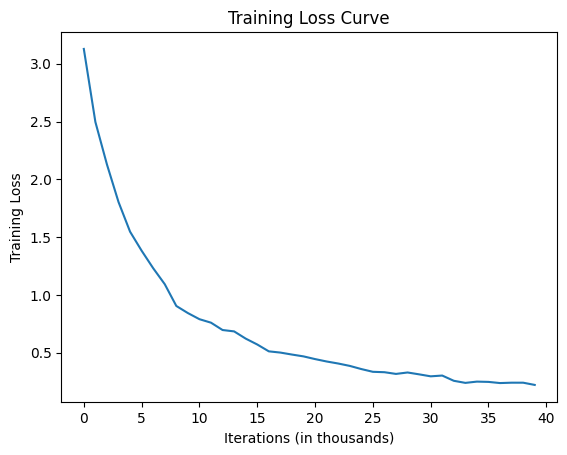

In [ ]:
num_epochs = 5
train_losses = []
if __name__ == '__main__':
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(tqdm(trainloader), 0):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = asl_net(inputs)

      loss = loss_asl(outputs, labels)
      optimizer_asl.zero_grad()

      loss.backward()
      optimizer_asl.step()

      running_loss += loss.item()

      if i % 1000 == 999:  # print every 1000 mini-batche
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
        train_losses.append(running_loss / 1000)
        running_loss = 0.0


    print('Finished Training')

# Plot the training loss curve
plt.plot(train_losses)
plt.xlabel('Iterations (in thousands)')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

Test Accuracy: 92.99%
Test recall: 92.99%
Test precision: 92.99%
Test F1 Score: 92.99%


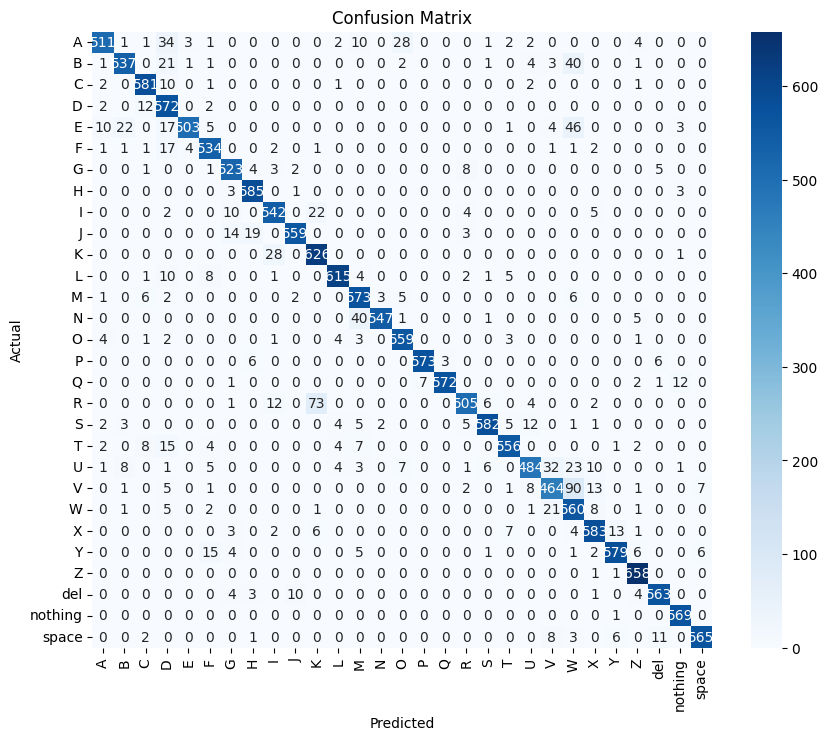

Test Accuracy: 92.99%


In [ ]:

asl_net.eval()  # Set the model to evaluation mode

# Define the criterion for the test
criterion = nn.CrossEntropyLoss()

# Test the model on the test set
total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    true_labels.extend(labels.numpy())
    labels = labels.to(device)
    outputs = asl_net(inputs)
    _, predicted = torch.max(outputs, 1)

    predicted_labels.extend(predicted.cpu().numpy())


    total_samples += labels.size(0)
    total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
recall = recall_score(true_labels, predicted_labels, average="micro")
precision = precision_score(true_labels, predicted_labels, average="micro")
f1 = f1_score(true_labels, predicted_labels, average="micro")
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test recall: {recall * 100:.2f}%')
print(f'Test precision: {precision * 100:.2f}%')
print(f'Test F1 Score: {f1 * 100:.2f}%')

confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f'Test Accuracy: {accuracy * 100:.2f}%')

We can see that we have smooth learning curv and good results but with adam we got better results.

### Open ended questions:

3. Which other loss function/s are suitable for the problem solved by the ASLNet?
Other

**Weighted Categorical Cross Entropy:**

Weighted Categorical Cross Entropy is a variant of the standard cross-entropy loss function that allows you to assign different weights to different classes.<br> This is particularly useful when you have class imbalances in your dataset, where some classes may be more prevalent or more important than others.<br>
our data set is well balanced, but we can use this function in our future for working with unbalanced data. <br>
$$L(y, \hat{y}) = - \sum_{i} w_i \cdot y_i \log(\hat{y}_i)$$
<br>

$y_i$ represents the ground truth probability distribution (typically one-hot encoded vectors)\
$\hat{y}_i$ represents the predicted probability distribution (output of the neural network)\
$w_i$ represents the weight assigned to class $i$
<br>

**Focal Loss**

Focal Loss is a dynamic loss function designed to address class imbalance and focus training on hard examples. It down-weights well-classified examples, allowing the model to concentrate more on difficult samples. This is achieved by introducing a focusing parameter that modulates the loss contribution from each example based on its predicted probability.

$$
\text{FocalLoss} = -\frac{1}{N}\sum_{i=1}^{N} \sum_{j=1}^{C} [y_{ij}(1 - p_{ij})^\gamma \log(p_{ij})]
$$

Where:
- $N$ is the number of samples.
- $C$ is the number of classes.
- $y_{ij}$ is 1 if the sample $i$ belongs to class $j$ and 0 otherwise.
- $p_{ij}$ is the predicted probability that sample $i$ belongs to class $j$.
- $\gamma$ is the focusing parameter controlling the rate at which easy examples are down-weighted.

### Batch Size

5. The current implemented batch size is 8. Which other batch size could we work with? 

Lets set the batch size to 16, it is a common practice to set batch sizes with power of two which suppose to utilize the hardware better, we would like the training no to take much longer than before so we are not setting the batch size too high, lowering the batch size can potentially (but not neccesarily) harm the results as each step will be based on a small set. Our training set, which consists of 0.8*87000=69600 is also divisible by 16.

In [ ]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
learning_rate = 0.001
asl_net = ASLNet(input_size=input_size, num_channels=3).to(device)
loss_asl = nn.CrossEntropyLoss()
optimizer_asl = torch.optim.SGD(asl_net.parameters(), lr=learning_rate)
# Decays the learning rate of each parameter group by gamma every step_size epochs
# By looking at previus runs, after 1 epoch the loss curve starts to jitter up and down and generally less smooth, lets reduce the learning rate a bit at each epoch so we will make smaller steps
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_asl,  step_size=1, gamma=0.8)


 18%|█▊        | 1006/5438 [00:28<02:00, 36.69it/s]

[1,  1000] loss: 2.985


 37%|███▋      | 2004/5438 [00:52<01:22, 41.78it/s]

[1,  2000] loss: 2.255


 55%|█████▌    | 3004/5438 [01:19<01:10, 34.63it/s]

[1,  3000] loss: 1.851


 74%|███████▎  | 4004/5438 [01:46<00:38, 36.92it/s]

[1,  4000] loss: 1.529


 92%|█████████▏| 5005/5438 [02:14<00:13, 33.15it/s]

[1,  5000] loss: 1.277


100%|██████████| 5438/5438 [02:27<00:00, 36.88it/s]


Finished Training


 18%|█▊        | 1002/5438 [00:32<02:19, 31.84it/s]

[2,  1000] loss: 1.007


 37%|███▋      | 2003/5438 [01:01<01:48, 31.80it/s]

[2,  2000] loss: 0.888


 55%|█████▌    | 3002/5438 [01:33<01:20, 30.24it/s]

[2,  3000] loss: 0.793


 74%|███████▎  | 4006/5438 [02:06<00:44, 32.42it/s]

[2,  4000] loss: 0.704


 92%|█████████▏| 5006/5438 [02:36<00:13, 31.53it/s]

[2,  5000] loss: 0.668


100%|██████████| 5438/5438 [02:50<00:00, 31.89it/s]


Finished Training


 18%|█▊        | 1004/5438 [00:31<02:32, 29.10it/s]

[3,  1000] loss: 0.557


 37%|███▋      | 2003/5438 [01:02<01:46, 32.33it/s]

[3,  2000] loss: 0.513


 55%|█████▌    | 3006/5438 [01:33<01:15, 32.17it/s]

[3,  3000] loss: 0.486


 74%|███████▎  | 4004/5438 [02:04<00:43, 33.22it/s]

[3,  4000] loss: 0.442


 92%|█████████▏| 5003/5438 [02:35<00:12, 33.49it/s]

[3,  5000] loss: 0.407


100%|██████████| 5438/5438 [02:48<00:00, 32.20it/s]


Finished Training


 18%|█▊        | 1003/5438 [00:32<02:10, 34.03it/s]

[4,  1000] loss: 0.359


 37%|███▋      | 2002/5438 [01:03<01:52, 30.65it/s]

[4,  2000] loss: 0.364


 55%|█████▌    | 3004/5438 [01:35<01:19, 30.69it/s]

[4,  3000] loss: 0.335


 74%|███████▎  | 4004/5438 [02:07<00:44, 32.05it/s]

[4,  4000] loss: 0.330


 92%|█████████▏| 5002/5438 [02:38<00:14, 29.82it/s]

[4,  5000] loss: 0.300


100%|██████████| 5438/5438 [02:52<00:00, 31.45it/s]


Finished Training


 18%|█▊        | 1005/5438 [00:31<02:14, 32.94it/s]

[5,  1000] loss: 0.288


 37%|███▋      | 2005/5438 [01:02<01:51, 30.79it/s]

[5,  2000] loss: 0.266


 55%|█████▌    | 3006/5438 [01:33<01:17, 31.35it/s]

[5,  3000] loss: 0.249


 74%|███████▎  | 4002/5438 [02:05<00:48, 29.82it/s]

[5,  4000] loss: 0.237


 92%|█████████▏| 5004/5438 [02:35<00:14, 30.03it/s]

[5,  5000] loss: 0.241


100%|██████████| 5438/5438 [02:48<00:00, 32.21it/s]


Finished Training


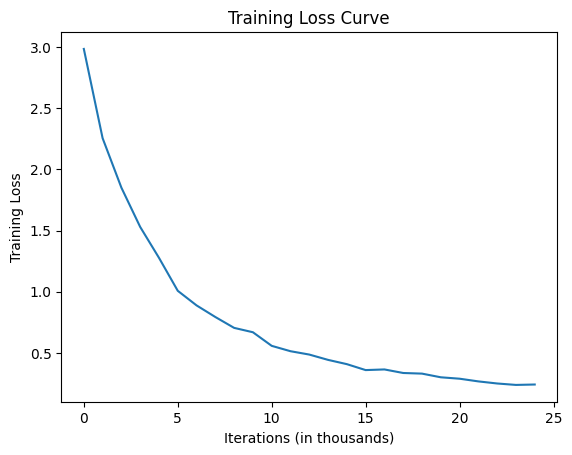

In [ ]:
num_epochs = 5
train_losses = []
if __name__ == '__main__':
  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, data in enumerate(tqdm(trainloader), 0):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = asl_net(inputs)

      loss = loss_asl(outputs, labels)
      optimizer_asl.zero_grad()

      loss.backward()
      optimizer_asl.step()

      running_loss += loss.item()

      if i % 1000 == 999:  # print every 1000 mini-batche
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 1000))
        train_losses.append(running_loss / 1000)
        running_loss = 0.0


    print('Finished Training')

# Plot the training loss curve
plt.plot(train_losses)
plt.xlabel('Iterations (in thousands)')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

Test Accuracy: 92.78%
Test recall: 92.78%
Test precision: 92.78%
Test F1 Score: 92.78%


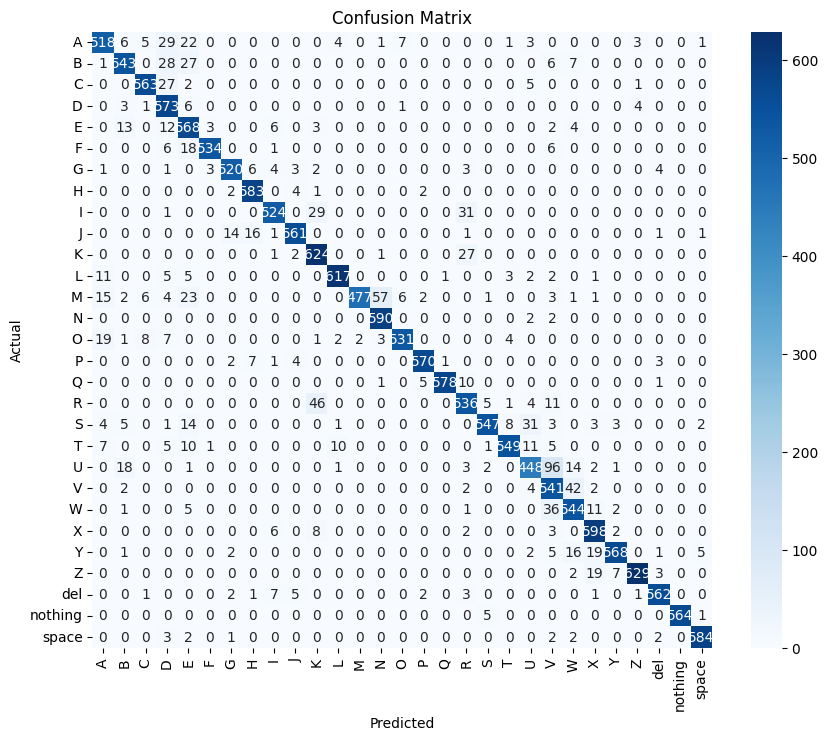

Test Accuracy: 92.78%


In [ ]:

asl_net.eval()  # Set the model to evaluation mode

# Define the criterion for the test
criterion = nn.CrossEntropyLoss()

# Test the model on the test set
total_correct = 0
total_samples = 0
true_labels = []
predicted_labels = []
with torch.no_grad():
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    true_labels.extend(labels.numpy())
    labels = labels.to(device)
    outputs = asl_net(inputs)
    _, predicted = torch.max(outputs, 1)
    predicted_labels.extend(predicted.cpu().numpy())


    total_samples += labels.size(0)
    total_correct += (predicted == labels).sum().item()

accuracy = total_correct / total_samples
recall = recall_score(true_labels, predicted_labels, average="micro")
precision = precision_score(true_labels, predicted_labels, average="micro")
f1 = f1_score(true_labels, predicted_labels, average="micro")
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Test recall: {recall * 100:.2f}%')
print(f'Test precision: {precision * 100:.2f}%')
print(f'Test F1 Score: {f1 * 100:.2f}%')

confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
print(f'Test Accuracy: {accuracy * 100:.2f}%')

We can see that the batch size didn't change much.

To conclude, we got the best results with relu function and adam optimizer, like the original setup.
We can try and add layers and try different random tranformation like rotations. Experiment with other LR schedulers like reducing on plateu.
We can give a try with the other loss functions we mentioned (But I guess they won't be  better as they mainly improve results on imbalnced datasets)